<a href="https://colab.research.google.com/github/SharonEstivalez/FisicaComputacional1/blob/master/Actividad%206/Actividad6_Sharon.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ***$$ACTIVIDAD  \space 6$$***



Pacheco Rodriguez Sharon Estivalez

 19/ 02/ 21
 

In [101]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#Bibliotecas para el análisis de series de tiempo y modelos de pronóstico
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima_model import ARIMAResults
from statsmodels.tsa.stattools import acf, pacf

import pandas.util.testing as tm

#Suprimir mensajes de alertas de cambios futuros
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Matplotlib mostrará los resultados en la Notebook de Jupyter
%matplotlib inline

In [102]:
#Tomar url en raw
url = 'https://raw.githubusercontent.com/SharonEstivalez/FisicaComputacional1/master/Actividad%203/10090.txt'

#Nombres para las columnas
col =  ['Fecha', 'Precip', 'Evap', 'Tmax', 'Tmin'] 

# encoding='cp1251' Windows (Europa Occidental)
# sep='\s+' el separador de datos es de uno o más espacios
#header=None no hay encabezado
#skiprows=19 Se brincará los primeros 19 renglones 
#skipfooter=1 Se brincará el último renglón
#engine='python' Se procesan los datos utilizando Python 
df_act = pd.read_csv(url, names=col, encoding='cp1251', sep='\s+', header=None, skiprows=19, skipfooter=1, engine='python')

#Hacer una copia del DataFrame
df_sp0 = df_act.copy()

#Reemplazar "Nulo" por espacio en blanco
str_Nulo = 'Nulo'
df_sp1 = df_sp0.replace(to_replace=str_Nulo, value='', regex=True)

#Convertir las valores de Precip, Evap, Tmax y Tmin en flotantes
cols_list = ['Precip', 'Evap', 'Tmax', 'Tmin']
for cols in cols_list:
  df_sp1[cols] = pd.to_numeric(df_sp1[cols], errors='coerce')

#Hacer copia del DataFrame anterior para trabajar con ella

df_sp2 = df_sp1.copy()

#Tomar "Fecha" y convertirlo al formato fecha que entiende python
df_sp2['Fecha'] = pd.to_datetime(df_sp2['Fecha'], dayfirst=True).copy()


#Añadir dos columnas, año y fecha

df_sp2['Año'] = df_sp2['Fecha'].dt.year
df_sp2['Mes'] = df_sp2['Fecha'].dt.strftime('%b')


#Nueva copia para este trabajo
df_dm = df_sp2.copy()

#df_dm.info()
#print(df_dm.head())
#print(df_dm.tail())


#Copia del DataFrame 
df_dm_ts = df_dm.copy()

#El índice será la variable 'Fecha'
df_dm_ts = df_dm_ts.set_index('Fecha')

#Para verificar
df_dm_ts.info()
#print(df_dm_ts.head())
#print(df_dm_ts.tail())

#Hacer períodos de 30 años aprox
#1963-2018
df_63 = df_dm_ts[(df_dm_ts['Año'] >= 1963) & (df_dm_ts['Año'] < 1990)]
df_90 = df_dm_ts[(df_dm_ts['Año'] >= 1990) & (df_dm_ts['Año'] < 2018)]


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 19592 entries, 1963-08-01 to 2018-12-31
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Precip  19558 non-null  float64
 1   Evap    17688 non-null  float64
 2   Tmax    19484 non-null  float64
 3   Tmin    19487 non-null  float64
 4   Año     19592 non-null  int64  
 5   Mes     19592 non-null  object 
dtypes: float64(4), int64(1), object(1)
memory usage: 1.0+ MB


#Probar estacionaridad con Prueba Aumentada de Dickey-Fuller

In [103]:
#Función para probar la estacionaridad de una serie de tiempo: 'timeseries'
   
def test_stationarity(df_ts):
    
#Determinar la Estadística de promedios móviles
    rolmean = df_ts.rolling(window=365, center=True).mean()
    rolstd = df_ts.rolling(window=365, center=True).std() #std Desviación estándar
    
#Define el tamaño de la figura
    plt.rcParams["figure.figsize"] = (12,6)

#Graficar la Estadística de promedios móviles 
    plt.plot(df_ts, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std Deviation')
 
    plt.legend(loc='best')
    plt.title('Promedio Móvil y Desviación Estándar')
    plt.grid()
    plt.show()
 
#Realiza la Prueba Aumentada de Dickey-Fuller:
    print('Resultados de la Prueba de Dickey-Fuller:')
    dftest = adfuller(df_ts, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], 
                         index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)


In [104]:
#Serie de tiempo a probar

#Copia

#Fecha inicio: 2008-01, fin: 2014-01
start, end = '2006-01', '2010-12'

ts_90 = df_90.loc[start:end].copy()
ts_90.head()


,Precip,Evap,Tmax,Tmin,Año,Mes
Fecha,,,,,,
2006-01-01,0.0,4.2,25.0,0.5,2006,Jan
2006-01-02,0.0,2.2,25.0,0.0,2006,Jan
2006-01-03,0.0,3.2,26.0,1.0,2006,Jan
2006-01-04,0.0,4.2,22.0,4.0,2006,Jan
2006-01-05,0.0,3.4,24.0,0.0,2006,Jan


In [106]:
#Definir serie de tiempo con Tmax 

ts_test1 = ts_90['Tmax'].copy()

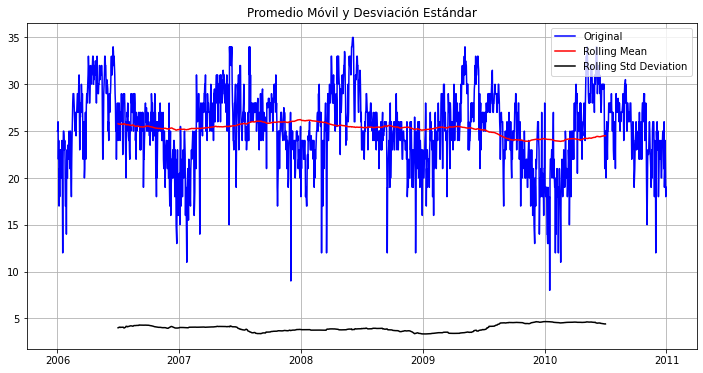

Resultados de la Prueba de Dickey-Fuller:
Test Statistic                   -4.630619
p-value                           0.000113
#Lags Used                       13.000000
Number of Observations Used    1812.000000
Critical Value (1%)              -3.433964
Critical Value (5%)              -2.863136
Critical Value (10%)             -2.567620
dtype: float64


In [107]:
#Realizar la prueba de estacionaridad para Tmax
test_stationarity(ts_test1)

Como el valor de p=0.000113 y, este es menor a 0.05, podemos considerar que la serie de tiempo es estacionaria. Además su promedio móvil y desviación estándar parecen ser constantes.

In [108]:
#Definir serie de tiempo con Tmin

ts_test2 = ts_90['Tmin'].copy()

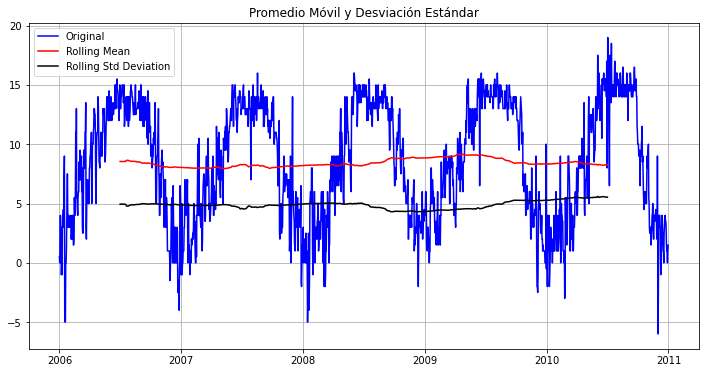

Resultados de la Prueba de Dickey-Fuller:
Test Statistic                   -2.580712
p-value                           0.097050
#Lags Used                       12.000000
Number of Observations Used    1813.000000
Critical Value (1%)              -3.433962
Critical Value (5%)              -2.863136
Critical Value (10%)             -2.567619
dtype: float64


In [109]:
#Realizar la prueba de estacionaridad para Tmin
test_stationarity(ts_test2)

Como p > 0.05 la serie no es estacionaria.
Realizar transformaciones para que la serie sea estacionaria.

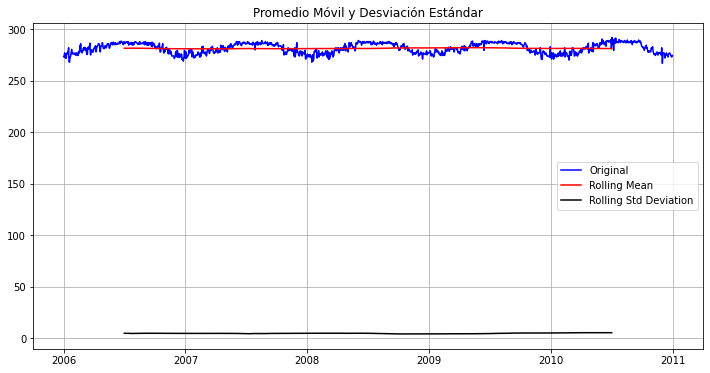

Resultados de la Prueba de Dickey-Fuller:
Test Statistic                   -2.580712
p-value                           0.097050
#Lags Used                       12.000000
Number of Observations Used    1813.000000
Critical Value (1%)              -3.433962
Critical Value (5%)              -2.863136
Critical Value (10%)             -2.567619
dtype: float64


In [96]:
#Transformar a grados Kelvin las temperaturas mínimas
ts_test2_k = ts_test2 + 273.15

test_stationarity(ts_test2_k)

Continuar transformando

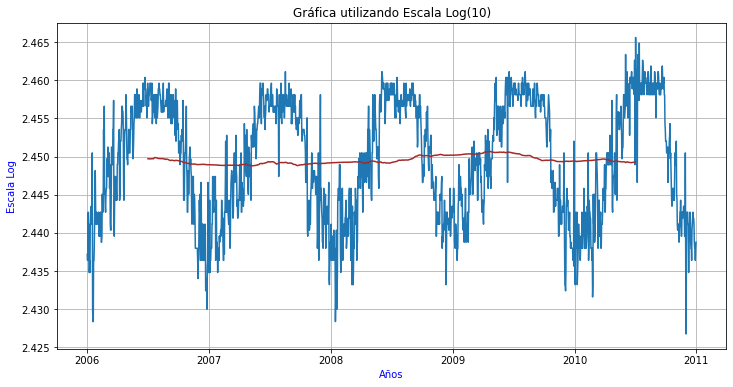

In [110]:
#Graficar en escala logaritmo base 10
ts_test2_k_log = np.log10(ts_test2_k)

moving_avg = ts_test2_k_log.rolling(365, center=True).mean()

plt.plot(ts_test2_k_log)
plt.plot(moving_avg, color = 'brown')
plt.xlabel('Años',color='b')
plt.ylabel('Escala Log',color='b')
plt.title('Gráfica utilizando Escala Log(10)')
plt.grid()
plt.show();


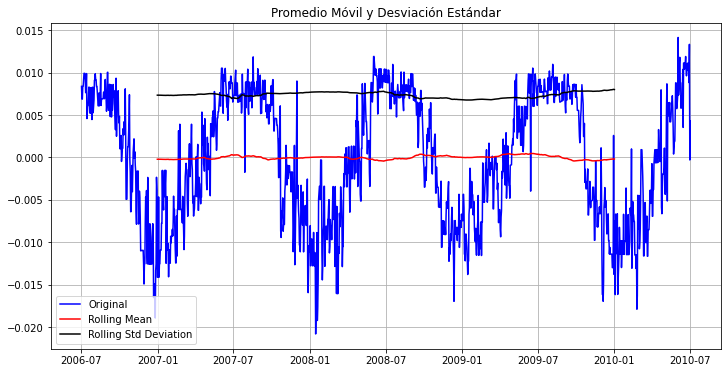

Resultados de la Prueba de Dickey-Fuller:
Test Statistic                   -2.551630
p-value                           0.103412
#Lags Used                       12.000000
Number of Observations Used    1449.000000
Critical Value (1%)              -3.434871
Critical Value (5%)              -2.863537
Critical Value (10%)             -2.567833
dtype: float64


In [111]:
ts_test2_k_log_moving_ave_diff = ts_test2_k_log - moving_avg 
ts_test2_k_log_moving_ave_diff.dropna(inplace=True)
test_stationarity(ts_test2_k_log_moving_ave_diff)

Sigue sin ser estacionaria la serie de Tmin, continuar transformando

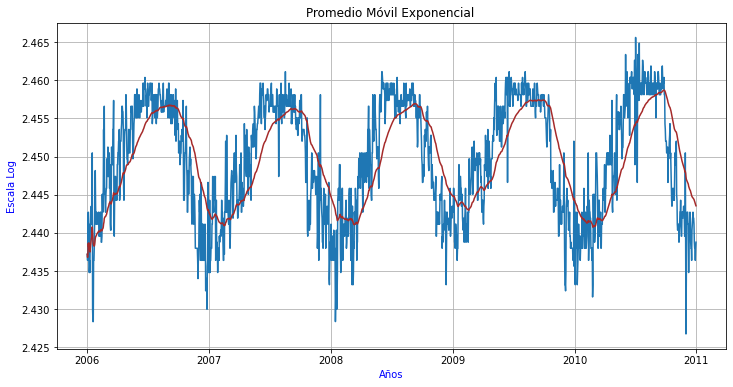

In [115]:
#Repetimos el cálculo usando promedios móviles exponenciales, 
#el parámetro 'halflife' representa el número de días que tienen cierta influencia
#en el promedio, pero su influencia decae exponencialmente.  

EWM_avg = ts_test2_k_log.ewm(halflife=30).mean()
plt.plot(ts_test2_k_log)
plt.plot(EWM_avg, color = 'brown')
plt.xlabel('Años',color='b')
plt.ylabel('Escala Log',color='b')
plt.title('Promedio Móvil Exponencial ')
plt.grid()
plt.show();

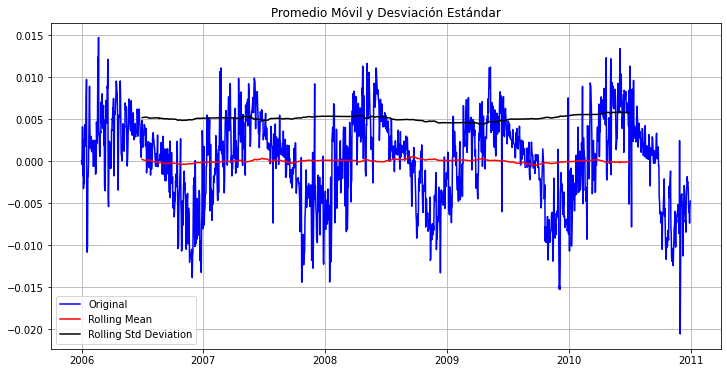

Resultados de la Prueba de Dickey-Fuller:
Test Statistic                   -3.168761
p-value                           0.021866
#Lags Used                       16.000000
Number of Observations Used    1809.000000
Critical Value (1%)              -3.433970
Critical Value (5%)              -2.863139
Critical Value (10%)             -2.567621
dtype: float64


In [116]:
#Probar estacionaridad de la diferencia 
ts_test2_k_log_EWM_avg_diff = ts_test2_k_log - EWM_avg 

test_stationarity(ts_test2_k_log_EWM_avg_diff)


La serie ya es estacionaria, ya que p es menor a 0.05

# **Estacionalidad**

 Métodos para eliminar la Estacionalidad:


*  *Diferenciación discreta* :
calcular diferencias involucrando un corrimiento 'shift()'.
*   *Descomposición* :
Tendencia + Estacionalidad + Residuo.


**Para Tmax**

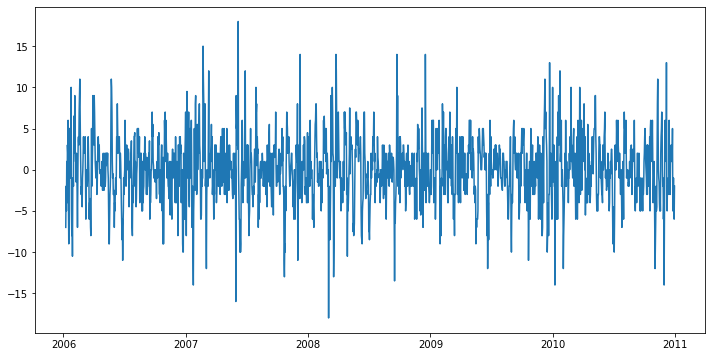

In [122]:
#Tmax
#Diferenciamos usando la función df.shift()
ts_test1_diff = ts_test1 - ts_test1.shift(periods=7)
plt.plot(ts_test1_diff);


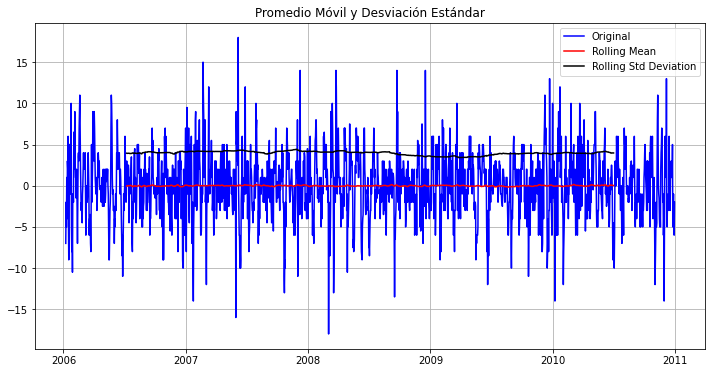

Resultados de la Prueba de Dickey-Fuller:
Test Statistic                -1.131988e+01
p-value                        1.181347e-20
#Lags Used                     2.100000e+01
Number of Observations Used    1.797000e+03
Critical Value (1%)           -3.433994e+00
Critical Value (5%)           -2.863150e+00
Critical Value (10%)          -2.567627e+00
dtype: float64


In [123]:
#Tmax
#Probamos la estacionaridad
ts_test1_diff.dropna(inplace=True)
test_stationarity(ts_test1_diff)


In [124]:
#Tmax
#Número de datos utilizados
len(ts_test1_diff)

1819

**Para Tmin**

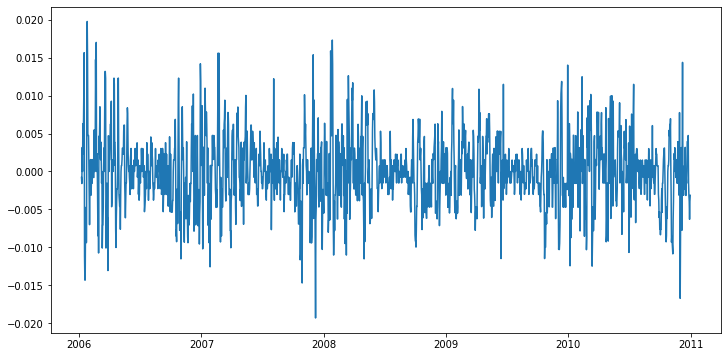

In [126]:
#Tmin
#Diferenciamos usando la función df.shift()
ts_test2_k_log_diff = ts_test2_k_log - ts_test2_k_log.shift(periods=7)
plt.plot(ts_test2_k_log_diff);

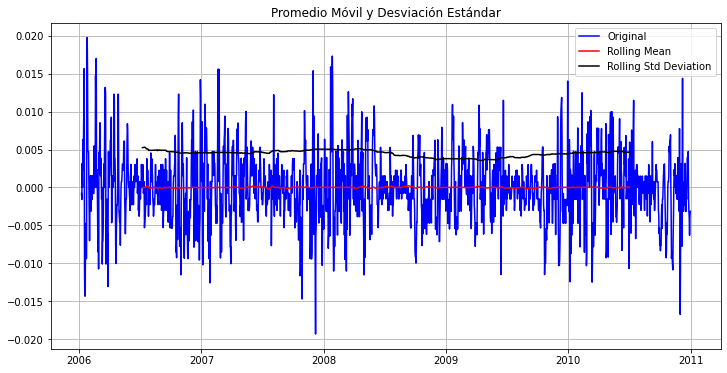

Resultados de la Prueba de Dickey-Fuller:
Test Statistic                -7.190660e+00
p-value                        2.508724e-10
#Lags Used                     2.400000e+01
Number of Observations Used    1.794000e+03
Critical Value (1%)           -3.434000e+00
Critical Value (5%)           -2.863152e+00
Critical Value (10%)          -2.567628e+00
dtype: float64


In [127]:
#Tmin
#Probar la estacionaridad
ts_test2_k_log_diff.dropna(inplace=True)
test_stationarity(ts_test2_k_log_diff)

In [128]:
#Tmin
#Número de datos utilizados
len(ts_test2_k_log_diff)

1819

 ***$$Pronósticos \space de \space series \space de \space tiempo$$*** 

# **ARIMA**

**Para Tmax**

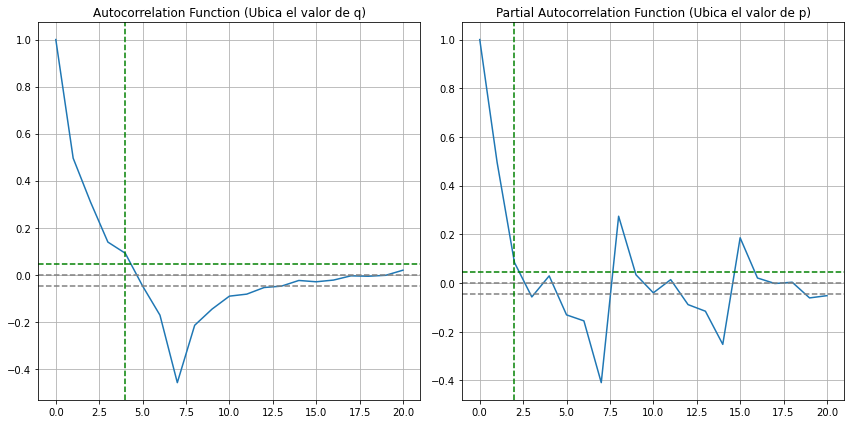

In [130]:
#Para Tmax

#Aplicamos ARIMA

lag_acf = acf(ts_test1_diff, nlags=20)
lag_pacf = pacf(ts_test1_diff, nlags=20, method = 'ols')

#Tamaño de las gráficas
plt.rcParams["figure.figsize"] = (12,6)

#Gráfica de ACF (Autocorrelation Function)
plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_test1_diff)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_test1_diff)), linestyle='--', color='green')
# Graficamos unas líneas verticales como referencias
#plt.axvline(x=3, linestyle='--', color='green')
plt.axvline(x=4, linestyle='--', color='green')
plt.grid()
plt.title('Autocorrelation Function (Ubica el valor de q)')

# Gráfica de PACF (Partial Autocorrelation Function)
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_test1_diff)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_test1_diff)), linestyle='--', color='green')
# Graficamos unas líneas verticales como referencias 
plt.axvline(x=2, linestyle='--', color='green')
plt.grid()
plt.title('Partial Autocorrelation Function (Ubica el valor de p)')

plt.tight_layout()


q=4 y
p=2

**Para Tmin**

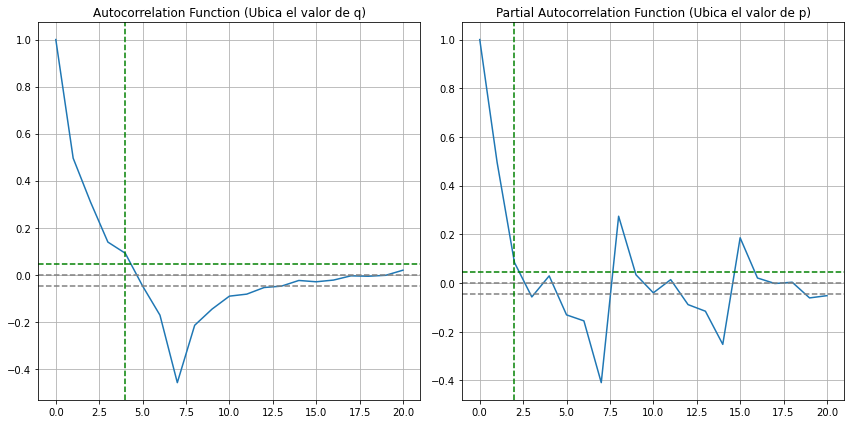

In [141]:
#Para Tmin
#Aplicamos ARIMA

lag_acf2 = acf(ts_test2_k_log_diff, nlags=20)
lag_pacf2 = pacf(ts_test2_k_log_diff, nlags=20, method = 'ols')

# Tamaño de las gráficas
plt.rcParams["figure.figsize"] = (12,6)

# Gráfica de ACF (Autocorrelation Function)
plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_test2_k_log_diff)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_test2_k_log_diff)), linestyle='--', color='green')
# Graficamos unas líneas verticales como referencias
#plt.axvline(x=3, linestyle='--', color='green')
plt.axvline(x=4, linestyle='--', color='green')
plt.grid()
plt.title('Autocorrelation Function (Ubica el valor de q)')

# Gráfica de PACF (Partial Autocorrelation Function)
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_test2_k_log_diff)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_test2_k_log_diff)), linestyle='--', color='green')
# Graficamos unas líneas verticales como referencias 
plt.axvline(x=2, linestyle='--', color='green')
plt.grid()
plt.title('Partial Autocorrelation Function (Ubica el valor de p)')

plt.tight_layout()


q=4 y p=2

# **Modelo AR (Auto-Regresión)**

**Para Tmax**

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:                 D.Tmax   No. Observations:                 1825
Model:                 ARIMA(2, 1, 0)   Log Likelihood               -4323.295
Method:                       css-mle   S.D. of innovations              2.586
Date:                Sat, 20 Feb 2021   AIC                           8654.590
Time:                        10:25:58   BIC                           8676.627
Sample:                    01-02-2006   HQIC                          8662.719
                         - 12-31-2010                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -0.0034      0.040     -0.085      0.933      -0.081       0.075
ar.L1.D.Tmax    -0.3664      0.023    -15.850      0.000      -0.412      -0.321
ar.L2.D.Tmax    -0.1558      0.023     -6.74

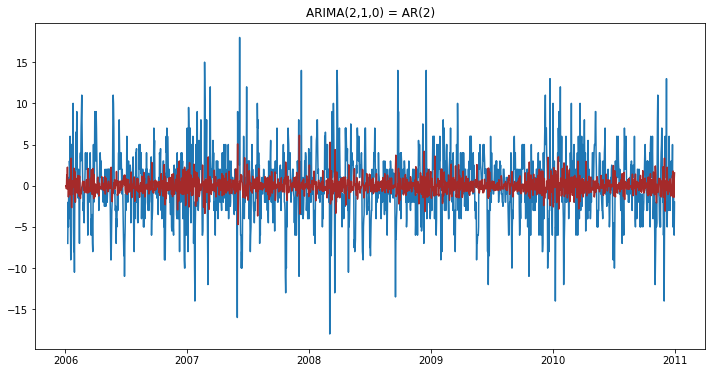

In [131]:
#Modelo AR(p): (p,d,q) = (2,1,0) 
model = ARIMA(ts_test1, order=(2,1,0), missing='drop')
results_AR = model.fit(displ=-1)
plt.plot(ts_test1_diff)
plt.plot(results_AR.fittedvalues, color='brown')
plt.title('ARIMA(2,1,0) = AR(2)')
print(results_AR.summary())

**Para Tmin**

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:                 D.Tmin   No. Observations:                 1825
Model:                 ARIMA(2, 1, 0)   Log Likelihood                8076.581
Method:                       css-mle   S.D. of innovations              0.003
Date:                Sat, 20 Feb 2021   AIC                         -16145.162
Time:                        11:02:31   BIC                         -16123.125
Sample:                    01-02-2006   HQIC                        -16137.033
                         - 12-31-2010                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const          6.37e-07   4.59e-05      0.014      0.989   -8.94e-05    9.06e-05
ar.L1.D.Tmin    -0.2834      0.023    -12.342      0.000      -0.328      -0.238
ar.L2.D.Tmin    -0.1931      0.023     -8.41

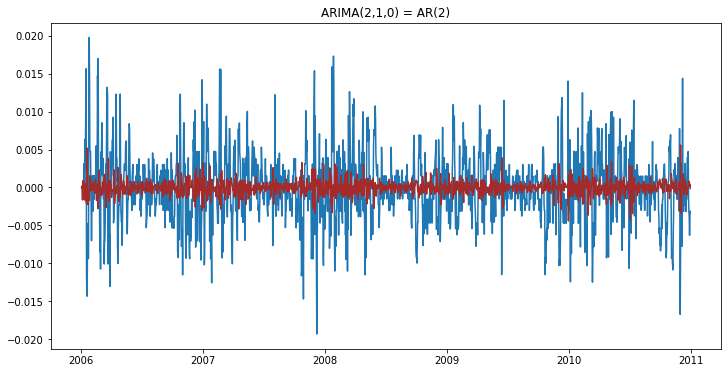

In [142]:
#Para Tmin
#Modelo AR(p): (p,d,q) = (2,1,0) 
model2 = ARIMA(ts_test2_k_log, order=(2,1,0), missing='drop')
results_AR2 = model2.fit(displ=-1)
plt.plot(ts_test2_k_log_diff)
plt.plot(results_AR2.fittedvalues, color='brown')
plt.title('ARIMA(2,1,0) = AR(2)')
print(results_AR2.summary())


# **Modelo MA (Promedio Móvil)**

**Para Tmax**

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:                 D.Tmax   No. Observations:                 1825
Model:                 ARIMA(0, 1, 4)   Log Likelihood               -4239.912
Method:                       css-mle   S.D. of innovations              2.470
Date:                Sat, 20 Feb 2021   AIC                           8491.824
Time:                        10:29:00   BIC                           8524.880
Sample:                    01-02-2006   HQIC                          8504.017
                         - 12-31-2010                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -0.0007      0.011     -0.058      0.954      -0.023       0.022
ma.L1.D.Tmax    -0.4710      0.023    -20.141      0.000      -0.517      -0.425
ma.L2.D.Tmax    -0.1357      0.025     -5.43

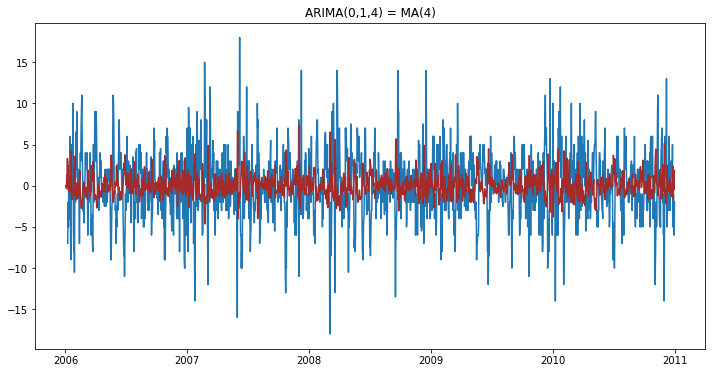

In [132]:
#Modelo MA(q): (p,d,q) = (0,1,4) 
model = ARIMA(ts_test1, order=(0,1,4), missing='drop')
results_MA = model.fit(displ=-1)
plt.plot(ts_test1_diff)
plt.plot(results_MA.fittedvalues, color='brown')
plt.title('ARIMA(0,1,4) = MA(4)')
print(results_MA.summary())

**Para Tmin**

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:                 D.Tmin   No. Observations:                 1825
Model:                 ARIMA(0, 1, 4)   Log Likelihood                8143.962
Method:                       css-mle   S.D. of innovations              0.003
Date:                Sat, 20 Feb 2021   AIC                         -16275.924
Time:                        11:06:14   BIC                         -16242.868
Sample:                    01-02-2006   HQIC                        -16263.730
                         - 12-31-2010                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const          3.98e-07   1.84e-05      0.022      0.983   -3.56e-05    3.64e-05
ma.L1.D.Tmin    -0.3750      0.023    -16.067      0.000      -0.421      -0.329
ma.L2.D.Tmin    -0.1926      0.025     -7.78

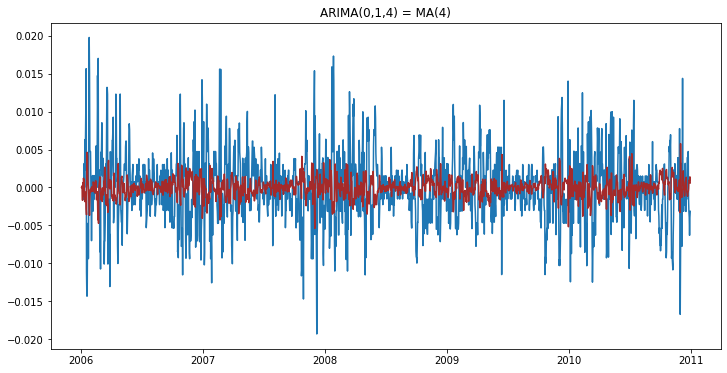

In [143]:
# Modelo MA(q): (p,d,q) = (0,1,4) 
model2 = ARIMA(ts_test2_k_log, order=(0,1,4), missing='drop')
results_MA2 = model2.fit(displ=-1)
plt.plot(ts_test2_k_log_diff)
plt.plot(results_MA2.fittedvalues, color='brown')
plt.title('ARIMA(0,1,4) = MA(4)')
print(results_MA2.summary())


# **Modelo ARIMA (Auto-Regresión + Promedio Móvil)**

**Para Tmax**

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:                 D.Tmax   No. Observations:                 1825
Model:                 ARIMA(2, 1, 4)   Log Likelihood               -4230.794
Method:                       css-mle   S.D. of innovations              2.457
Date:                Sat, 20 Feb 2021   AIC                           8477.589
Time:                        10:31:18   BIC                           8521.663
Sample:                    01-02-2006   HQIC                          8493.847
                         - 12-31-2010                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -0.0005      0.010     -0.054      0.957      -0.019       0.018
ar.L1.D.Tmax    -0.0891      0.200     -0.446      0.655      -0.480       0.302
ar.L2.D.Tmax     0.5066      0.108      4.68

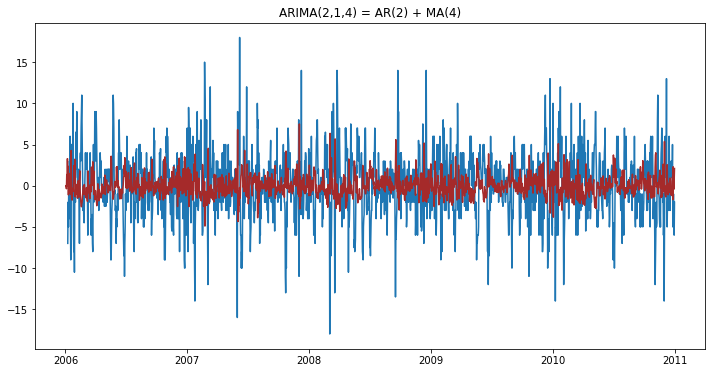

In [133]:
# Modelo ARIMA(p): (p,d,q) = (2,1,4) 
model = ARIMA(ts_test1, order=(2,1,4), missing='drop')
results_ARIMA = model.fit(displ=-1)
plt.plot(ts_test1_diff)
plt.plot(results_ARIMA.fittedvalues, color='brown')
plt.title('ARIMA(2,1,4) = AR(2) + MA(4)')
print(results_ARIMA.summary())


In [135]:
#Definir una serie de tiempo con las predicciones obtenidas por el método ARIMA
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
print(predictions_ARIMA_diff)

Fecha
2006-01-02   -0.000519
2006-01-03   -0.000683
2006-01-04   -0.366981
2006-01-05    1.356496
2006-01-06   -0.075405
                ...   
2010-12-27    2.296681
2010-12-28    0.188387
2010-12-29   -0.428732
2010-12-30    0.567914
2010-12-31    2.092456
Length: 1825, dtype: float64


In [137]:
#Sumar las predicciones de ARIMA a la serie observada (ts_test1)
predictions_ARIMA = pd.Series(ts_test1, index = ts_test1.index)
predictions_ARIMA = predictions_ARIMA.add(predictions_ARIMA_diff)
print(predictions_ARIMA.head())
print(predictions_ARIMA.tail())

Fecha
2006-01-01          NaN
2006-01-02    24.999481
2006-01-03    25.999317
2006-01-04    21.633019
2006-01-05    25.356496
dtype: float64
Fecha
2010-12-27    23.296681
2010-12-28    24.188387
2010-12-29    20.571268
2010-12-30    18.567914
2010-12-31    21.092456
dtype: float64


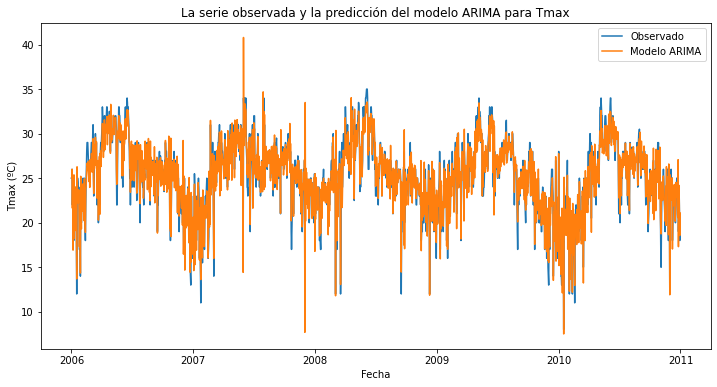

In [155]:
# Regresamos a la escala de Temperatura original (no hubo movimiento para Tmax)
#predictions_ARIMA = 10**(predictions_ARIMA_log)
# Graficamos la serie original y las predicciones con ARIMA

# Tamaño de las gráficas
plt.rcParams["figure.figsize"] = (12,6)

plt.plot(ts_test1, label='Observado');
plt.plot(predictions_ARIMA, label='Modelo ARIMA');
plt.xlabel('Fecha')
plt.ylabel('Tmax (ºC)')
plt.title('La serie observada y la predicción del modelo ARIMA para Tmax')
plt.legend(loc='best');


In [156]:
#Calculamos el RMSE (Root Mean Square Error - Error de la Raiz Cuadrada de la Media)

RMSE = np.sqrt(np.mean((predictions_ARIMA - ts_test1)**2))
print('RMSE:', RMSE)

RMSE: 1.2551279203405783


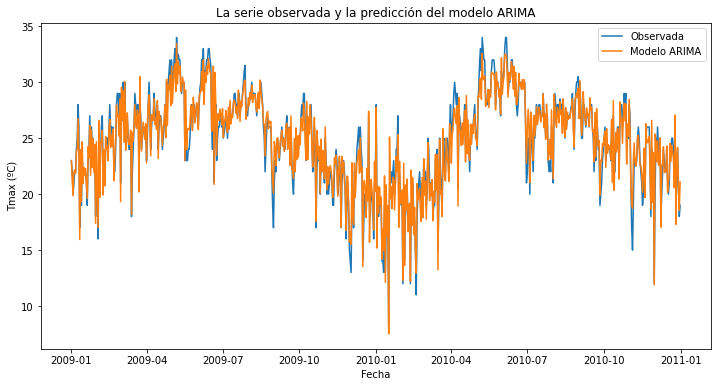

In [140]:
#Graficar sólo los útimos datos de las series 
ts_test1_last = ts_test1.tail(730)
predictions_ARIMA_last = predictions_ARIMA.tail(730)
plt.plot(ts_test1_last, label='Observada');
plt.plot(predictions_ARIMA_last, label='Modelo ARIMA');
plt.xlabel('Fecha')
plt.ylabel('Tmax (ºC)')
plt.title('La serie observada y la predicción del modelo ARIMA')
plt.legend(loc='best');


**Para Tmin**

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


                             ARIMA Model Results                              
Dep. Variable:                 D.Tmin   No. Observations:                 1825
Model:                 ARIMA(2, 1, 4)   Log Likelihood                8144.472
Method:                       css-mle   S.D. of innovations              0.003
Date:                Sat, 20 Feb 2021   AIC                         -16272.945
Time:                        11:09:21   BIC                         -16228.870
Sample:                    01-02-2006   HQIC                        -16256.686
                         - 12-31-2010                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const         3.925e-07    1.8e-05      0.022      0.983   -3.48e-05    3.56e-05
ar.L1.D.Tmin    -0.0125      2.088     -0.006      0.995      -4.104       4.079
ar.L2.D.Tmin     0.1825      1.043      0.17

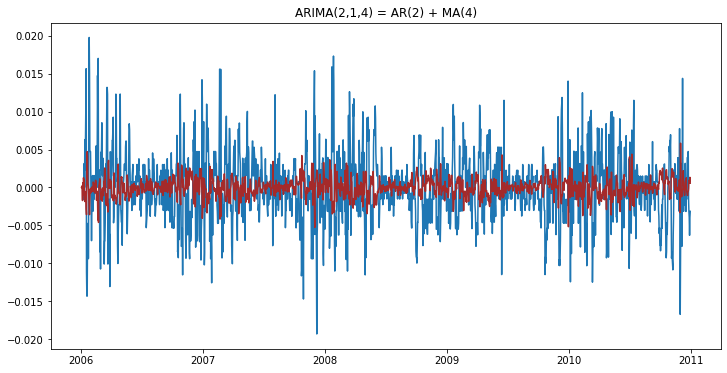

In [144]:
#Modelo ARIMA(p): (p,d,q) = (2,1,4) 
model2 = ARIMA(ts_test2_k_log, order=(2,1,4), missing='drop')
results_ARIMA2 = model2.fit(displ=-1)
plt.plot(ts_test2_k_log_diff)
plt.plot(results_ARIMA2.fittedvalues, color='brown')
plt.title('ARIMA(2,1,4) = AR(2) + MA(4)')
print(results_ARIMA2.summary())

In [145]:
#Definir una serie de tiempo con las predicciones obtenidas por el método ARIMA
predictions_ARIMA_diff2 = pd.Series(results_ARIMA2.fittedvalues, copy=True)
print(predictions_ARIMA_diff2)

Fecha
2006-01-02    3.925225e-07
2006-01-03    1.887355e-04
2006-01-04   -2.949346e-04
2006-01-05   -1.726477e-03
2006-01-06    6.361418e-04
                  ...     
2010-12-27    7.723800e-04
2010-12-28    9.815035e-04
2010-12-29    8.506290e-04
2010-12-30    1.331243e-03
2010-12-31    5.603064e-04
Length: 1825, dtype: float64


In [146]:
#Sumar las predicciones de ARIMA a la serie observada (ts_test2_k_log)
predictions_ARIMA_log2 = pd.Series(ts_test2_k_log, index = ts_test2_k_log.index)
predictions_ARIMA_log2 = predictions_ARIMA_log2.add(predictions_ARIMA_diff2)
print(predictions_ARIMA_log2.head())
print(predictions_ARIMA_log2.tail())

Fecha
2006-01-01         NaN
2006-01-02    2.436402
2006-01-03    2.438177
2006-01-04    2.442420
2006-01-05    2.434675
dtype: float64
Fecha
2010-12-27    2.438761
2010-12-28    2.438970
2010-12-29    2.437252
2010-12-30    2.439319
2010-12-31    2.439340
dtype: float64


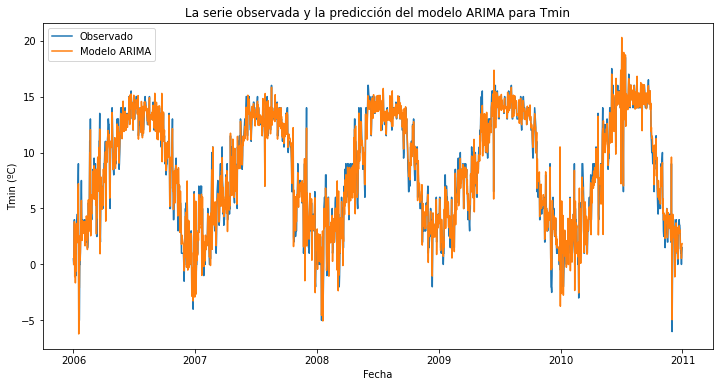

In [159]:
#Regresar a la escala de Temperatura original y a Celsius
predictions_ARIMA2 = 10**(predictions_ARIMA_log2)
predictions_ARIMA2 = predictions_ARIMA2 - 273.15
ts_test2_k2 = ts_test2_k - 273.15
# Graficamos la serie original y las predicciones con ARIMA

# Tamaño de las gráficas
plt.rcParams["figure.figsize"] = (12,6)

plt.plot(ts_test2_k2, label='Observado');
plt.plot(predictions_ARIMA2, label='Modelo ARIMA');
plt.xlabel('Fecha')
plt.ylabel('Tmin (ºC)')
plt.title('La serie observada y la predicción del modelo ARIMA para Tmin')
plt.legend(loc='best');


In [160]:
# Calculamos el RMSE (Root Mean Square Error - Error de la Raiz Cuadrada de la Media)

RMSE = np.sqrt(np.mean((predictions_ARIMA2 - ts_test2_k2)**2))
print('RMSE:', RMSE)


RMSE: 0.774912481561113


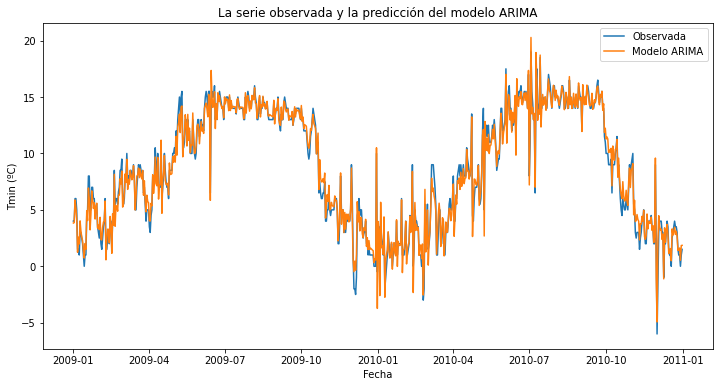

In [161]:
#Graficar sólo los útimos datos de las series 
ts_test2_last = ts_test2_k2.tail(730)
predictions_ARIMA_last2 = predictions_ARIMA2.tail(730)
plt.plot(ts_test2_last, label='Observada');
plt.plot(predictions_ARIMA_last2, label='Modelo ARIMA');
plt.xlabel('Fecha')
plt.ylabel('Tmin (ºC)')
plt.title('La serie observada y la predicción del modelo ARIMA')
plt.legend(loc='best');
